## Augmented Optimal Steps Model

This notebook implements an **Augmented Optimal Steps Model** for simulating pedestrian traffic on a staircase with agents traveling both **up** and **down**. It incorporates:

- **Poisson arrivals** of groups
- **Group dynamics** (shared velocity, social norms, collision avoidance)
- **Individual agent movement** via local utility maximization (stepping candidates)
- **Heat‐map logging** of where foot placements occur

Below is a high‐level overview of the classes, attributes, and simulation steps.

---

### **Classes and Their Roles**

1. **`Agent`**  
   - **Attributes**  
     - `unique_id`, `age`, `sex`, `height`, `weight`  
     - `direction` ("ascending" or "descending")  
     - `velocity`, `desired_step_radius`, `max_step_radius`  
     - `current_position`, `next_position`  
     - `destination`  
     - `social_convention`, `propensity_to_follow`  
     - `time_steps_to_update` (how many ticks before the next move)  
     - `active` (whether the agent is still on the staircase)  
   - **Methods**  
     - `sample_candidates(staircase)`: Generates possible next foot placements within physical constraints.  
     - `update_position(utility_function, agents, staircase)`: Chooses the best candidate via the utility function, updates `current_position` / `next_position`, and adds the footstep to the stair’s log.

2. **`Group`**  
   - **Attributes**  
     - `group_id`, `direction`  
     - `bottom_funnel_vertices`, `top_funnel_vertices`  
     - `social_convention`, `propensity_to_follow`  
     - `group_size` (sampled from some distribution)  
     - `agents` (list of `Agent` objects in this group)  
   - **Purpose**  
     - When a group arrives, it spawns its `agents` in an initial formation outside the staircase. Each agent is assigned a destination near the top or bottom funnel, depending on `direction`.

3. **`Stair`**  
   - **Attributes**  
     - `vertices` (4 corners of the stair in 3D)  
     - `z` (constant height for the top surface)  
     - `steps` (a list of all foot placements made here)  
   - **Methods**  
     - `add_step(x, y, agent)`: Records a footstep.  
     - `plot_heat_map()`: Basic 3D scatter or color map to visualize ascending vs. descending foot traffic.

4. **`Staircase`**  
   - **Attributes**  
     - `num_stairs`, `step_widths`, `step_depths`, `step_heights`  
     - `funnel_length`, `funnel_width_start`, `funnel_width_end`  
     - `stairs` (list of `Stair` objects for bottom funnel, actual steps, top funnel)  
   - **Methods**  
     - `_compute_all_vertices()`: Builds polygonal coordinates for each stair/funnel.  
     - `draw()`: Renders a 3D view showing each stair and optionally footstep data.

5. **`Simulation`**  
   - **Attributes**  
     - `staircase` (the `Staircase` instance)  
     - `lambda_rate` (Poisson arrival rate of groups)  
     - `simulation_duration` (how long the simulation runs)  
     - `propensity_to_follow`, `social_convention` (global defaults)  
     - `group_size_distribution` (function returning size of each arriving group)  
     - `prob_ascending` (probability a new group is ascending)  
     - `time` (current simulation step)  
     - `agents` (global list of all agents spawned so far)  
     - `arrival_times` (list of future arrival times from the Poisson process)  
   - **Key Methods**  
     - `generate_poisson_arrivals(rate, duration)`: Creates the schedule of group arrivals.  
     - `simulate()`: 
       1. Increments time.  
       2. Spawns a new `Group` if the current time matches a scheduled arrival.  
       3. Updates each active `Agent`’s position if it’s time.  
       4. Logs footsteps (`Stair.add_step(...)`) as agents move.  
       5. Deactivates agents that reach their final destination.  
     - `utility_function(...)`: Evaluates candidate positions based on:  
       - Distance to destination,  
       - Collision avoidance,  
       - Group cohesion,  
       - Social convention (walk on a particular side),  
       - Desired step size, etc.

---

### **Simulation Flow**

1. **Initialization**  
   - Create a `Staircase` object.  
   - Define simulation parameters.  
   - Instantiate a `Simulation` with these inputs.

2. **Arrival of Groups**  
   - A Poisson process decides when each group arrives.  
   - Each group’s direction (`ascending` vs. `descending`) is random based on `prob_ascending`.  
   - A new `Group` object spawns multiple `Agent`s, each with random attributes like age, velocity, etc.

3. **Agent Movement**  
   - At each time step, agents who are ready (i.e. `time_steps_to_update == 0`) sample next‐step candidates.  
   - The best candidate (highest utility) is chosen, and the foot placement is logged in `Stair.add_step(...)`.  
   - The agent sets a new `time_steps_to_update` based on the stepping distance and velocity.

4. **Data Logging & Heat Maps**  
   - Each `Stair` stores a record of all `(x,y,agent)` footsteps.  
   - `plot_heat_map()` can be called to visualize how frequently each part of the stair is used by ascending or descending traffic.

5. **Results**  
   - A final dataset of steps is produced, showing exactly where and when agents placed their feet.  
   - These data can be aggregated over many runs or used directly for load/pressure analyses on each stair.

By capturing individual stepping choices, group behavior, and two‐way traffic constraints, the **Augmented Optimal Steps Model** provides a way to study how people navigate complex staircases under varying crowd conditions and social conventions.


In [179]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import csv
import math
import random 

## Agent Class

In [180]:
class Agent:
    def __init__(self, unique_id, age, sex, height, weight, desired_velocity, direction, group_id, position, destination, social_convention, propensity_to_follow):
        self.unique_id = unique_id
        self.age = age
        self.sex = sex
        self.height = height
        self.weight = weight
        self.velocity = desired_velocity
        self.direction = direction
        self.group_id = group_id
        self.current_position = position # (x, y, stair_index)
        self.next_position = position # both feet together at instantiation
        self.foot_length = 0.15 * self.height
        self.foot_width = 0.4 * self.foot_length
        self.active = True
        self.desired_step_radius = 0.4 * height
        self.max_step_radius = 1.5 * self.desired_step_radius
        self.destination = destination # (x,y,z) coordinates, no stair_index 
        self.time_steps_to_update = 0
        self.social_convention = social_convention
        self.propensity_to_follow = propensity_to_follow

    
    def sample_candidates(self, staircase):
        """
        Generates a list of possible positions for the agent's next step.

        Args:
            staircase (Staircase): The staircase object.

        Returns:
            list: A list of valid candidate positions (x, y, z, velocity).
        """
        candidates = []
        max_stride = self.max_step_radius  # Maximum stride length for the agent
        current_x, current_y, current_z = self.current_position

        for _ in range(200):  # Generate 200 random candidate positions
            # Sample random displacements
            dx = np.random.uniform(-max_stride, max_stride)
            
            if self.direction == "ascending":
                dy = np.random.uniform(0, max_stride)  # Positive y-direction for ascending
                dz = np.random.choice([0, 1])         # Ascend or stay
            else:
                dy = np.random.uniform(-max_stride, 0) # Negative y-direction for descending
                dz = np.random.choice([0, -1])        # Descend or stay

            # Convert dz to height displacement
            current_stair_idx = self.current_position[2]
            next_stair_idx = current_stair_idx + dz
            current_height = staircase.stairs[current_stair_idx].z
            next_height = staircase.stairs[next_stair_idx].z

            dz_height = abs(current_height - next_height)

            # Check 3D Euclidean stride length
            if np.sqrt(dx**2 + dy**2 + dz_height**2) > max_stride:
                continue

            # Calculate candidate position
            candidate_x = current_x + dx
            candidate_y = current_y + dy
            candidate_z = current_z + dz  # This is the stair index!!

            # Validate position on the staircase
            if not (0 <= candidate_z <= staircase.num_stairs and self._is_within_stair(candidate_x, candidate_y, candidate_z, staircase)):
                continue

            # Check foot placement validity
            if not self._is_valid_foot_placement(candidate_x, candidate_y, candidate_z, staircase):
                continue

            # Add candidate to the list
            candidates.append((candidate_x, candidate_y, candidate_z, self.velocity))

        return candidates



  
    def _is_within_stair(self, x, y, z, staircase):
        """
        Checks if a candidate position is within the stair's dimensions.

        Args:
            x (float): X-coordinate of the candidate position.
            y (float): Y-coordinate of the candidate position.
            z (int): Stair index of the candidate position.
            staircase (Staircase): The staircase object.

        Returns:
            bool: True if the position is within the stair bounds, False otherwise.
        """
        from shapely.geometry import Point, Polygon  # Ensure you have Shapely installed

        # Extract the vertices for the specified stair
        stair_vertices = staircase.stairs[z].vertices

        # Create a polygon using the stair vertices (assumes vertices are in a valid order)
        stair_polygon = Polygon(stair_vertices)

        # Create a point using the candidate (x, y)
        point = Point(x, y)

        # Check if the point lies within the polygon (or on its boundary)
        return stair_polygon.contains(point) or stair_polygon.touches(point)

        

    def _is_valid_foot_placement(self, x, y, z, staircase):
        if z <= 0 or z >= staircase.num_stairs:
            return True

        prev_depth_end = sum(staircase.step_depths[:z])
        if self.direction == "ascending":
            foot_end_y = y + self.foot_length / 2
            return foot_end_y <= prev_depth_end
        else:
            # For descending, you might check the front of the step differently
            foot_front_y = y - self.foot_length / 2
            return foot_front_y >= prev_depth_end - staircase.step_depths[z - 1]

        


    def update_position(self, utility_function, agents, staircase):
        """
        Updates the agent's position and velocity based on the utility function. 
        When the front foot is placed:
          next_position becomes current position
          the current position is added to the list for the stair that it falls on
          the placement of the other foot is decided upon (next_position) based on the previous position of that foot

        Args:
            utility_function (callable): The utility function to evaluate candidates.
            agents (list): List of all agents.
            staircase (Staircase): The staircase object.
        """
        if not self.active:
            return

        # Sample candidates for the agent's next position
        candidates = self.sample_candidates(staircase=staircase)


        # Find the best candidate based on utility
        best_utility = float('-inf')
        best_candidate = None
        for candidate in candidates:

            utility = utility_function(self, agents, staircase, candidate, self.social_convention, self.propensity_to_follow)
            if utility > best_utility:
                best_utility = utility
                best_candidate = candidate

        temp_position = self.next_position # needed for 3 way swap 

        # Update position and velocity based on the best candidate
        if best_candidate:
            self.next_position = (best_candidate[0], best_candidate[1], best_candidate[2])  # (x,y, stair_index)
            self.velocity = best_candidate[3]

        previous_position = self.current_position

        self.current_position = temp_position # This is the step!
        staircase.stairs[self.current_position[2]].add_step(self.current_position[0], self.current_position[1], self) # add the step to that stair so we have it on our heat map later

        # Replace stair index with the actual z value for next_position and previous_position
        next_position_with_z = (
            self.next_position[0],
            self.next_position[1],
            staircase.stairs[self.next_position[2]].z
        )
        previous_position_with_z = (
            previous_position[0],
            previous_position[1],
            staircase.stairs[previous_position[2]].z
        )

        # Compute the time steps to update
        self.time_steps_to_update = round(
            10 * np.linalg.norm(np.array(previous_position_with_z) - np.array(next_position_with_z)) / self.velocity
        )
       

        # Check if the agent has reached the destination
        if self.current_position[2] >= staircase.num_stairs and self.direction == "ascending" or self.current_position[2] <= 0 and self.direction == "descending":
            self.active = False

        

## Group Class

In [181]:
class Group:
    def __init__(self, group_id, bottom_funnel_vertices, top_funnel_vertices, direction, num_stairs, group_size, social_convention, propensity_to_follow):
        """
        Initialize a Group.

        Parameters:
        - group_id: Unique identifier for the group.
        - bottom_funnel_vertices: The four vertices of the bottom funnel (bottom left, bottom right, top right, top left).
        - top_funnel_vertices: The four vertices of the top funnel (bottom left, bottom right, top right, top left).
        - direction: "ascending" or "descending".
        - num_stairs: The number of stairs on the staircase (doesn't include the top funnel so we don't need to subtract 1 to stair_idx).
        - social_convention
        - propensity_to_follow
        """
        self.group_id = group_id
        self.bottom_funnel_vertices = bottom_funnel_vertices
        self.top_funnel_vertices = top_funnel_vertices
        self.direction = direction
        self.social_convention = social_convention 
        self.propensity_to_follow = propensity_to_follow

        # Sample group size from a right-skewed distribution (e.g., exponential distribution).
        self.group_size = group_size
        self.agents = []

        # Set destination and initial y-position based on direction.
        if direction == "ascending":
            destination = np.mean(top_funnel_vertices, axis=0)
            stair_idx = 0
            y_position = bottom_funnel_vertices[0][1]  # Bottom funnel y-coordinate
        else:
            destination = np.mean(bottom_funnel_vertices, axis=0)  # Average position of bottom funnel vertices
            stair_idx = num_stairs 
            y_position = top_funnel_vertices[3][1]  # Top funnel y-coordinate

        # Assign a uniform velocity for the group.
        group_velocity = np.random.uniform(0.5, 1.5)  # Random velocity in m/s

        # Instantiate agents
        for i in range(self.group_size):
            unique_id = f"Group{group_id}_Agent{i}"
            x_position = i  # Space agents by 1 meter starting from x = 0

            # Sample attributes for the agent.
            age = np.random.randint(10, 70)  # Age between 10 and 70
            sex = np.random.choice(["M", "F"])
            height = np.random.normal(1.7, 0.1)  # Average height: 1.7 meters, std dev: 0.1 meters
            weight = np.random.normal(70, 15)  # Average weight: 70 kg, std dev: 15 kg

            # Create an Agent and set its initial position.
            position = (x_position, y_position, stair_idx)
            agent = Agent(
                unique_id, age, sex, height, weight, group_velocity, direction,
                group_id, position, destination, self.social_convention, self.propensity_to_follow
            )

            self.agents.append(agent)


## Stair Class

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_2562/4254685817.py:70: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([z_min, z_max])


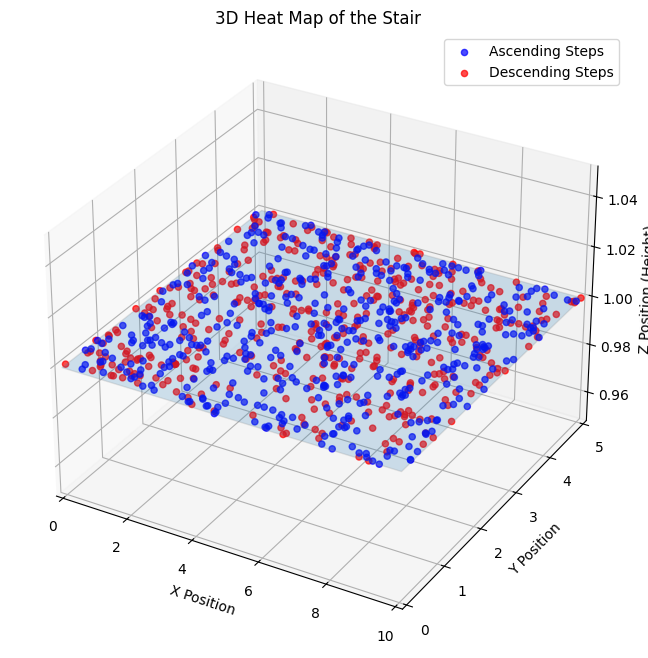

In [182]:
class Stair:
    def __init__(self, vertices):
        """
        Represents a single stair step or funnel.

        Args:
            vertices (list): List of (x, y, z) coordinates defining the vertices of the stair.
        """
        self.vertices = vertices  # Coordinates of the stair vertices (x, y, z)
        self.z = vertices[0][2]  # All vertices share the same Z-coordinate (flat surface)
        self.steps = []  # List to store steps (x, y, z, Agent)

    def add_step(self, x, y, agent):
        """
        Add a step to the list of steps. The Z-coordinate is automatically set to the stair's Z-level.

        Args:
            x (float): X-coordinate of the step.
            y (float): Y-coordinate of the step.
            agent (Agent): The Agent object that made the step.
        """
        self.steps.append({"x": x, "y": y, "z": self.z, "agent": agent})

    def plot_heat_map(self):
        """
        Plot a heat map of the stair, including a lightly shaded outline of its surface.
        Ensure the plot is scaled to include the entire surface.
        """
        # Separate ascending and descending steps
        ascending_steps = [(step['x'], step['y'], step['z']) for step in self.steps if step['agent'].direction == 'ascending']
        descending_steps = [(step['x'], step['y'], step['z']) for step in self.steps if step['agent'].direction == 'descending']

        # Create scatter plot data
        if ascending_steps:
            asc_x, asc_y, asc_z = zip(*ascending_steps)
        else:
            asc_x, asc_y, asc_z = [], [], []

        if descending_steps:
            desc_x, desc_y, desc_z = zip(*descending_steps)
        else:
            desc_x, desc_y, desc_z = [], [], []

        # Calculate bounds for scaling the plot
        all_x = [v[0] for v in self.vertices] + list(asc_x) + list(desc_x)
        all_y = [v[1] for v in self.vertices] + list(asc_y) + list(desc_y)
        all_z = [v[2] for v in self.vertices] + list(asc_z) + list(desc_z)

        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)
        z_min, z_max = min(all_z), max(all_z)

        # Create the heat map
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Add scatter plot for steps
        ax.scatter(asc_x, asc_y, asc_z, c='blue', label='Ascending Steps', alpha=0.7)
        ax.scatter(desc_x, desc_y, desc_z, c='red', label='Descending Steps', alpha=0.7)

        # Add the lightly shaded outline of the stair surface
        if self.vertices:
            # Use the vertices to create a polygon
            poly = Poly3DCollection([self.vertices], alpha=0.2, edgecolor='gray')
            ax.add_collection3d(poly)

        # Set axis limits to include the entire surface
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

        # Set axis labels and title
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_zlabel('Z Position (Height)')
        ax.set_title('3D Heat Map of the Stair')
        ax.legend()

        plt.show()
    def plot_pressure_map(self, c=1.3):
        """
        NEW method: Plot a 3D heat map where the color encodes the PRESSURE from each footstep.

        Ascending steps => foot is an ellipse => area = π * (L/2)*(W/2)
        Descending steps => foot is a circle => area = π * (W/2)^2

        Pressure = (weight * c) / foot_area
        - `weight` is agent.weight
        - `c` is a constant, default=1.3
        - L = 0.15 * agent.height
        - W = 0.06 * agent.height

        We color ascending steps in a 'Blues' colormap, descending steps in 'Reds'.
        """

        # Compute pressure for each step
        pressure_values = []
        for step in self.steps:
            agent = step["agent"]
            direction = agent.direction  # 'ascending' or 'descending'

            # Foot length & width from agent.height
            L = 0.15 * agent.height
            W = 0.06 * agent.height

            # FOOT AREA:
            if direction == "ascending":
                # Elliptical area
                foot_area = np.pi * (L / 2.0) * (W / 2.0)
            else:
                # direction == "descending": circular area with radius=(W/2)
                foot_area = np.pi * (W / 2.0) ** 2

            # Pressure = (weight * c) / area
            # If foot_area == 0 (edge case?), skip or set to 0
            if foot_area > 0:
                pressure = (agent.weight * c) / foot_area
            else:
                pressure = 0.0

            step["pressure"] = pressure
            pressure_values.append(pressure)

        if not pressure_values:
            print("No steps recorded for this stair.")
            return

        # min & max for uniform color scale
        min_p = min(pressure_values)
        max_p = max(pressure_values)


        # Separate ascending vs. descending steps & gather coordinates
        asc_x, asc_y, asc_z, asc_p = [], [], [], []
        desc_x, desc_y, desc_z, desc_p = [], [], [], []

        for step in self.steps:
            direction = step["agent"].direction
            x, y, z = step["x"], step["y"], step["z"]
            p = step["pressure"]

            if direction == "ascending":
                asc_x.append(x)
                asc_y.append(y)
                asc_z.append(z)
                asc_p.append(p)
            else:
                desc_x.append(x)
                desc_y.append(y)
                desc_z.append(z)
                desc_p.append(p)

        # ---------------------
        # 3) Set up figure & axis
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the stair outline
        if self.vertices:
            poly = Poly3DCollection([self.vertices], alpha=0.2, edgecolor='gray')
            ax.add_collection3d(poly)

        # Compute bounds so we can properly show entire surface
        all_x = [v[0] for v in self.vertices] + asc_x + desc_x
        all_y = [v[1] for v in self.vertices] + asc_y + desc_y
        all_z = [v[2] for v in self.vertices] + asc_z + desc_z
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)
        z_min, z_max = min(all_z), max(all_z)

        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

        # Create 3D scatter plot with color=pressure
        asc_plot = None
        desc_plot = None

        if asc_x:
            asc_plot = ax.scatter(
                asc_x, asc_y, asc_z, 
                c=asc_p, cmap='Blues', alpha=0.7,
                vmin=min_p, vmax=max_p
            )
        if desc_x:
            desc_plot = ax.scatter(
                desc_x, desc_y, desc_z,
                c=desc_p, cmap='Reds', alpha=0.7,
                vmin=min_p, vmax=max_p
            )

        # 5) Label axes & title
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_zlabel('Z Position (Height)')
        ax.set_title('Pressure Heat Map for the Stair')

        # ---------------------
        # 6) (Optional) Add colorbars
        if asc_plot:
            cbar_asc = fig.colorbar(asc_plot, ax=ax, shrink=0.5)
            cbar_asc.set_label('Ascending Pressure (Pa?)')  # or any unit
        if desc_plot:
            cbar_desc = fig.colorbar(desc_plot, ax=ax, shrink=0.5)
            cbar_desc.set_label('Descending Pressure')

        plt.show()


# Example usage
if __name__ == "__main__":
    # Define vertices for a single stair with a flat Z-coordinate
    vertices = [
        (0, 0, 1),  # All vertices have the same Z-coordinate
        (10, 0, 1),
        (10, 5, 1),
        (0, 5, 1)
    ]

    # Create a stair object
    stair = Stair(vertices=vertices)

    # Define an example Agent class (placeholder for the real Agent class)
    class AgentDummy:
        def __init__(self, unique_id, direction):
            self.unique_id = unique_id
            self.direction = direction

    # Create agents
    agents = [AgentDummy(unique_id=i, direction='ascending' if i % 2 == 0 else 'descending') for i in range(100)]

    # Simulate steps
    np.random.seed(42)
    for agent in agents:
        for _ in range(np.random.randint(5, 15)):
            x = np.random.uniform(0, 10)
            y = np.random.uniform(0, 5)
            stair.add_step(x, y, agent)

    # Plot the heat map
    stair.plot_heat_map()


## Staircase Class

Staircase Domain with Funnels on Each End

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


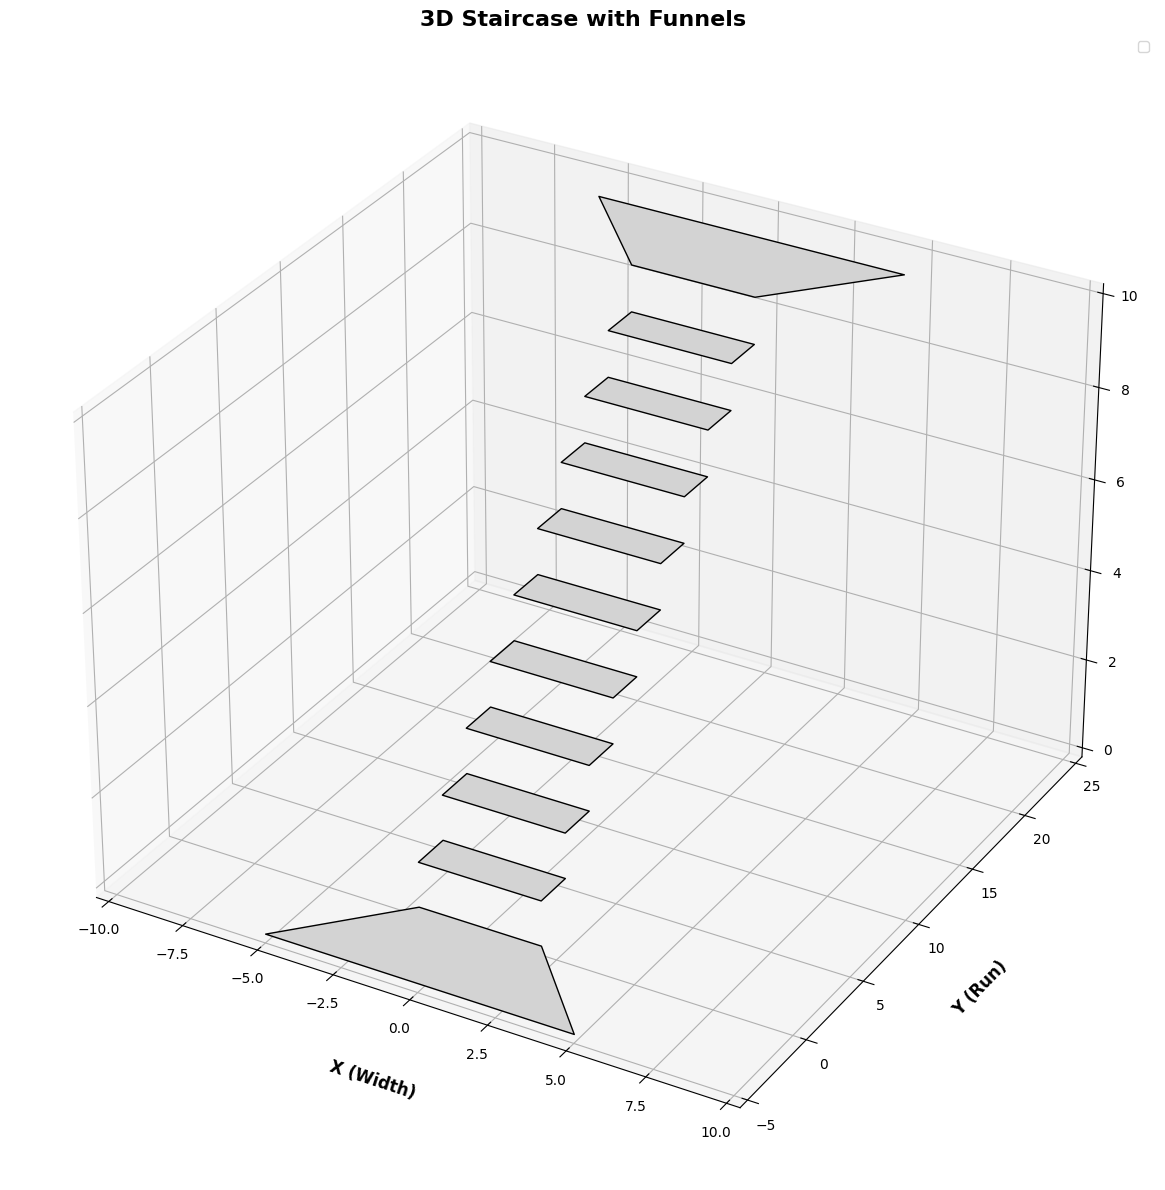

Stair 0:
  [-5.0, -5, 0]
  [5.0, -5, 0]
  [2.0, 0, 0]
  [-2.0, 0, 0]
Stair 1:
  [-2.0, 0, 1]
  [2.0, 0, 1]
  [2.0, 2, 1]
  [-2.0, 2, 1]
Stair 2:
  [-2.0, 2, 2]
  [2.0, 2, 2]
  [2.0, 4, 2]
  [-2.0, 4, 2]
Stair 3:
  [-2.0, 4, 3]
  [2.0, 4, 3]
  [2.0, 6, 3]
  [-2.0, 6, 3]
Stair 4:
  [-2.0, 6, 4]
  [2.0, 6, 4]
  [2.0, 8, 4]
  [-2.0, 8, 4]
Stair 5:
  [-2.0, 8, 5]
  [2.0, 8, 5]
  [2.0, 10, 5]
  [-2.0, 10, 5]
Stair 6:
  [-2.0, 10, 6]
  [2.0, 10, 6]
  [2.0, 12, 6]
  [-2.0, 12, 6]
Stair 7:
  [-2.0, 12, 7]
  [2.0, 12, 7]
  [2.0, 14, 7]
  [-2.0, 14, 7]
Stair 8:
  [-2.0, 14, 8]
  [2.0, 14, 8]
  [2.0, 16, 8]
  [-2.0, 16, 8]
Stair 9:
  [-2.0, 16, 9]
  [2.0, 16, 9]
  [2.0, 18, 9]
  [-2.0, 18, 9]
Stair 10:
  [-2.0, 18, 10]
  [2.0, 18, 10]
  [5.0, 23, 10]
  [-5.0, 23, 10]


In [183]:
class Staircase:
    def __init__(self, num_stairs, step_widths, step_depths, step_heights, funnel_length, funnel_width_start, funnel_width_end):
        """
        Initializes a staircase with aligned funnels and configurable steps.

        Args:
            num_stairs (int): Number of intermediary steps in the staircase
            step_widths (list): List of widths for each step.
            step_depths (list): List of depths (tread) for each step.
            step_heights (list): List of heights (rise) for each step.
            funnel_length (float): Length of both the top and bottom funnels.
            funnel_width_start (float): Width of the bottom funnel.
            funnel_width_end (float): Width of the top funnel.
        """
        self.num_stairs = num_stairs
        self.step_widths = step_widths
        self.step_depths = step_depths
        self.step_heights = step_heights
        self.funnel_length = funnel_length
        self.funnel_width_start = funnel_width_start
        self.funnel_width_end = funnel_width_end

        if not (len(step_widths) == len(step_depths) == len(step_heights) == num_stairs):
            raise ValueError("step_widths, step_depths, and step_heights must have the same length as num_stairs.")

        # This will hold Stair objects (bottom funnel, steps, top funnel)
        self.stairs = []
        self._compute_all_vertices()

    def _compute_all_vertices(self):
        """Computes the vertices for all steps and funnels and stores them as Stair objects."""
        # Bottom funnel
        bottom_funnel_vertices = [
            [-self.funnel_width_start / 2, -self.funnel_length, 0],
            [self.funnel_width_start / 2, -self.funnel_length, 0],
            [self.step_widths[0] / 2, 0, 0],
            [-self.step_widths[0] / 2, 0, 0],
        ]
        self.stairs.append(Stair(bottom_funnel_vertices))

        current_z = self.step_heights[0]
        current_y = 0
        # Build the (num_stairs-1) actual steps
        for i in range(self.num_stairs - 1):
            step_vertices = [
                [-self.step_widths[i] / 2, current_y, current_z],
                [self.step_widths[i] / 2, current_y, current_z],
                [self.step_widths[i] / 2, current_y + self.step_depths[i], current_z],
                [-self.step_widths[i] / 2, current_y + self.step_depths[i], current_z],
            ]
            self.stairs.append(Stair(step_vertices))

            # Update for next step
            current_z += self.step_heights[i+1]
            current_y += self.step_depths[i]

        # Top funnel
        top_funnel_vertices = [
            [-self.step_widths[-1] / 2, current_y, current_z],
            [self.step_widths[-1] / 2, current_y, current_z],
            [self.funnel_width_end / 2, current_y + self.funnel_length, current_z],
            [-self.funnel_width_end / 2, current_y + self.funnel_length, current_z],
        ]
        self.stairs.append(Stair(top_funnel_vertices))

    def print_vertices(self):
        """Prints the vertices of each stair, including the funnels."""
        for i, stair in enumerate(self.stairs):
            print(f"Stair {i}:")
            for vertex in stair.vertices:
                print(f"  {vertex}")

    def draw(self):
        """
        Draws the staircase including steps, funnels, and superimposed heat maps of the steps.
        """
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111, projection='3d')

        # Draw stairs and funnels
        for stair in self.stairs:
            vertices = np.array(stair.vertices)
            x = vertices[:, 0]
            y = vertices[:, 1]
            z = vertices[:, 2]
            poly = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(poly, facecolors='lightgray', edgecolors='black'))

        # Plot heat maps for steps
        for stair in self.stairs:
            ascending_steps = [(step["x"], step["y"], step["z"]) for step in stair.steps if step["agent"].direction == "ascending"]
            descending_steps = [(step["x"], step["y"], step["z"]) for step in stair.steps if step["agent"].direction == "descending"]

            if ascending_steps:
                asc_x, asc_y, asc_z = zip(*ascending_steps)
                ax.scatter(asc_x, asc_y, asc_z, c="blue", alpha=0.7, label="Ascending Steps")

            if descending_steps:
                desc_x, desc_y, desc_z = zip(*descending_steps)
                ax.scatter(desc_x, desc_y, desc_z, c="red", alpha=0.7, label="Descending Steps")

        # Set axis limits and labels
        # Set axis limits and labels
        ax.set_xlim(-self.funnel_width_start, self.funnel_width_start)
        ax.set_ylim(-self.funnel_length, self.funnel_length + sum(self.step_depths))
        ax.set_zlim(0, sum(self.step_heights))
        ax.set_xlabel("X (Width)", fontsize=12, fontweight="bold", labelpad=20)
        ax.set_ylabel("Y (Run)", fontsize=12, fontweight="bold", labelpad=20)
        ax.set_zlabel("Z (Riser)", fontsize=12, fontweight="bold", labelpad=20)
        ax.set_title("3D Staircase with Funnels", fontsize=16, fontweight="bold")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def export_stair_data_as_csv(self, nx, ny, csv_filename="stair_data.csv", slip_factor=0.001):
        """
        Export per-stair data (stairs 1..num_stairs-1) in an nx x ny grid to a CSV file,
        distributing each footstep's pressure & slip among ALL grid cells covered by the foot.

        Args:
            nx (int): Number of subdivisions in X direction
            ny (int): Number of subdivisions in Y direction
            csv_filename (str): Name of output CSV
            slip_factor (float): Multiply foot_length by this factor to get slip per footstep
                                (before distributing among covered cells).
        """
        import csv
        import math
    
        # Make sure each footstep has "pressure" computed (if not already)
        for stair in self.stairs:
            for step_dict in stair.steps:
                if "pressure" not in step_dict:
                    agent = step_dict["agent"]
                    direction = agent.direction
                    # Foot dimensions
                    L = 0.15 * agent.height  # foot length
                    W = 0.06 * agent.height  # foot width (for descending circle)

                    # Compute foot contact area
                    if direction == "ascending":
                        # Ellipse area
                        foot_area = math.pi * (L / 2.0) * (W / 2.0)
                    else:  # descending => circle area with radius = (W/2)
                        foot_area = math.pi * (W / 2.0) ** 2

                    if foot_area > 0:
                        step_dict["pressure"] = (agent.weight * 1.3) / foot_area
                    else:
                        step_dict["pressure"] = 0.0

        # Helper to check if a point (px,py) is inside the foot shape
        def point_in_footprint(px, py, foot_cx, foot_cy, direction, L, W):
            """
            Returns True if (px,py) is inside the foot shape (circle or ellipse).
            - ascending => ellipse (major axis = L along Y, minor axis = W along X)
            - descending => circle with radius=(W/2)
            """
            if direction == "ascending":
                # ellipse radii
                rx = W / 2.0  # half-diameter along x
                ry = L / 2.0  # half-diameter along y
                if rx == 0 or ry == 0:
                    return False
                val = ((px - foot_cx) / rx) ** 2 + ((py - foot_cy) / ry) ** 2
                return (val <= 1.0)
            else:
                # descending => circle with radius = W/2
                r = W / 2.0
                dist2 = (px - foot_cx) ** 2 + (py - foot_cy) ** 2
                return dist2 <= (r * r)

       
        # Open CSV file and write header
        with open(csv_filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["StairIndex", "Grid_i", "Grid_j",
                            "X_center", "Y_center",
                            "CumulativePressure", "CumulativeSlip"])

            # Iterate over actual steps: 1..(num_stairs-1) Skip 0 => bottom funnel, skip num_stairs => top funnel
            
            for s_idx in range(1, self.num_stairs):
                if s_idx >= len(self.stairs):
                    break  # sometimes top funnel is at exactly num_stairs

                stair_obj = self.stairs[s_idx]
                vertices = stair_obj.vertices
                if not vertices:
                    continue

                # bounding box for this stair
                x_vals = [v[0] for v in vertices]
                y_vals = [v[1] for v in vertices]
                x_min, x_max = min(x_vals), max(x_vals)
                y_min, y_max = min(y_vals), max(y_vals)

                # cell sizes
                dx = (x_max - x_min) / nx if nx > 0 else 0
                dy = (y_max - y_min) / ny if ny > 0 else 0

                # Build 2D arrays for accumulations
                pressure_grid = [[0.0 for _ in range(ny)] for _ in range(nx)]
                slip_grid = [[0.0 for _ in range(ny)] for _ in range(nx)]

                # Precompute cell-center coords for quick access
                # center_points[i][j] => (x_center, y_center)
                center_points = [[None for _ in range(ny)] for _ in range(nx)]
                for i in range(nx):
                    for j in range(ny):
                        cx = x_min + (i + 0.5) * dx
                        cy = y_min + (j + 0.5) * dy
                        center_points[i][j] = (cx, cy)

            
                # For each footstep on this stair, figure out which cells are covered by the foot => distribute pressure & slip
                for step_dict in stair_obj.steps:
                    x_foot = step_dict["x"]
                    y_foot = step_dict["y"]
                    p_foot = step_dict["pressure"]
                    agent = step_dict["agent"]
                    direction = agent.direction

                    L = 0.15 * agent.height
                    W = 0.06 * agent.height
                    # slip per footstep (before dividing among covered cells)
                    step_slip = (L * slip_factor)

                    # 1) find all cells whose centers are inside foot shape
                    covered_cells = []
                    for i in range(nx):
                        for j in range(ny):
                            (cx, cy) = center_points[i][j]
                            if point_in_footprint(cx, cy, x_foot, y_foot, direction, L, W):
                                covered_cells.append((i, j))

                    # 2) distribute pressure & slip among these cells
                    if covered_cells:
                        share = 1.0 / len(covered_cells)
                        for (i_c, j_c) in covered_cells:
                            pressure_grid[i_c][j_c] += (p_foot * share)
                            slip_grid[i_c][j_c] += (step_slip * share)

                # Write the final grid data for this stair to CSV
                for i in range(nx):
                    for j in range(ny):
                        cx, cy = center_points[i][j]
                        writer.writerow([
                            s_idx,           # Stair index
                            i, j,            # Cell indices
                            cx, cy,          # Center coords
                            pressure_grid[i][j],
                            slip_grid[i][j]
                        ])


# Example usage
staircase_with_funnels_aligned = Staircase(
    num_stairs=10,         # Number of intermediary steps
    step_widths=[4] * 10,  # Width of each step
    step_depths=[2] * 10,  # Depth of each step
    step_heights=[1] * 10, # Height of each step
    funnel_length=5,      # Length of the funnels
    funnel_width_start=10,# Width of the bottom funnel
    funnel_width_end=10   # Width of the top funnel
)

staircase_with_funnels_aligned.draw()
staircase_with_funnels_aligned.print_vertices()


## Simulation Class

In [184]:
class Simulation:
    def __init__(self, staircase_params, lambda_rate, simulation_duration, propensity_to_follow, group_size_distribution, prob_ascedning, social_convention):
        self.staircase = Staircase(**staircase_params)
        self.lambda_rate = lambda_rate
        self.simulation_duration = simulation_duration
        self.propensity_to_follow = propensity_to_follow
        self.group_size_distribution = group_size_distribution
        self.prob_ascending = prob_ascedning
        self.social_convention = social_convention
        self.time = 0
        self.agents = []
        self.arrival_times = self.generate_poisson_arrivals(lambda_rate, simulation_duration)

    @staticmethod
    def generate_poisson_arrivals(rate, duration):
        # Simulates a Poisson arrival process, returning a set of group arrival times
        arrivals = []
        current_time = 0

        while current_time < duration:
            # Generate interarrival time
            interarrival_time = np.random.exponential(1 / rate)
            current_time += interarrival_time
            if current_time < duration:
                arrivals.append(current_time)

        return arrivals


    def simulate(self):

        print(self.arrival_times)

        group_id = 0

        active_agents = [] # agents currently on the staircase or beginning funnel

        while self.time < self.simulation_duration:
            
            # Introduce groups according to the arrival times
            if len(self.arrival_times) > 0 and self.time >= self.arrival_times[0]:
                self.arrival_times = self.arrival_times[1:]  # Remove the first arrival time

                # decide whether direction is "ascending" or "descending" using self.prob_ascending which ranges from 0 to 1
                direction = "ascending" if random.random() < self.prob_ascending else "descending"

                bottom_funnel_vertices = self.staircase.stairs[0].vertices
                top_funnel_vertices = self.staircase.stairs[-1].vertices
                group_size = int(self.group_size_distribution())
                group = Group(group_id, bottom_funnel_vertices, top_funnel_vertices, direction, self.staircase.num_stairs, group_size, social_convention, propensity_to_follow)
                self.agents.extend(group.agents)
                active_agents.extend(group.agents)
                group_id += 1

            # Iterate only through active agents
            for agent in active_agents[:]:  # Use slicing to safely modify the list during iteration

                # we only should update the agent if it just placed its foot
                if agent.active:

                    if agent.time_steps_to_update == 0:
                        agent.update_position(
                            self.utility_function,
                            active_agents,
                            self.staircase
                        )
                    else:
                        agent.time_steps_to_update -= 1

                if not agent.active:
                    # Remove inactive agents directly
                    active_agents.remove(agent)

            self.time += 1


    @staticmethod
    def utility_function(agent, agents, staircase, candidate, social_convention, propensity_to_follow):
        """
        Evaluates the utility of a candidate position and velocity for an agent.
        """
        # Constants
        beta_radius = 0.5  # Weight for step radius penalty
        beta_collide = 1.0  # Collision penalty weight
        gamma_collide = 2.0  # Collision sensitivity
        beta_group = 0.5  # Group cohesion weight
        gamma_group = 2.0  # Group cohesion sensitivity
        beta_bound = 0.5  # Boundary penalty weight
        gamma_bound = 2.0  # Boundary sensitivity
        alpha1 = 1.0  # Weight for progress term
        alpha2 = 1.0  # Weight for comfort term

        x_c, y_c, z_c, v_c = candidate  # Candidate position and velocity

        # **Handle Staircase Width Correctly**
        if z_c == 0:
            staircase_width = staircase.funnel_width_start
        elif z_c == staircase.num_stairs:
            staircase_width = staircase.funnel_width_end
        else:
            staircase_width = staircase.step_widths[z_c - 1]  # Adjusted index

        dist_to_edge = min(abs(x_c), abs(staircase_width - x_c))
        u_boundary = -beta_bound * np.exp(-gamma_bound * dist_to_edge)

        # Progress term: movement toward destination with preferred velocity
        destination = agent.destination  
        u_progress = -np.linalg.norm([
            x_c - destination[0],
            y_c - destination[1],
            staircase.stairs[z_c].z - destination[2]
        ]) ** 2
        u_progress -= (v_c - agent.velocity) ** 2

        # Avoidance and Group Cohesion terms (as before)
        u_avoid = 0
        for other_agent in agents:
            if other_agent != agent:
                dist_future = (
                    np.linalg.norm([
                        x_c - other_agent.current_position[0],
                        y_c - other_agent.current_position[1],
                        staircase.stairs[z_c].z - staircase.stairs[other_agent.current_position[2]].z
                    ]) - (v_c + other_agent.velocity) * 0.5
                )
                if dist_future < 0.5:  # Hard collision constraint
                    return float('-inf')
                else:
                    u_avoid -= beta_collide * np.exp(-gamma_collide * dist_future)

        # Group cohesion term
        u_group = sum(
            beta_group * np.exp(-gamma_group * np.linalg.norm([
                x_c - a.current_position[0],
                y_c - a.current_position[1],
                staircase.stairs[z_c].z - staircase.stairs[a.current_position[2]].z
            ]))
            for a in agents if a.group_id == agent.group_id and a != agent
        )

        # Step radius penalty
        current_position = np.array([
            agent.current_position[0],
            agent.current_position[1],
            staircase.stairs[agent.current_position[2]].z
        ])
        candidate_position = np.array([x_c, y_c, staircase.stairs[z_c].z])
        step_distance = np.linalg.norm(candidate_position - current_position)
        delta = abs(step_distance - agent.desired_step_radius)
        u_step_radius = -beta_radius * delta ** 2

        if social_convention != "none":
            # For ascending agents, "right" side is + (width / 4). For descending, "right" side is − (width / 4).
            # Adjust signs as needed if you want the reverse.
            if agent.direction == "ascending":
                if social_convention == "right":
                    x_convention = staircase_width / 4.0
                elif social_convention == "left":
                    x_convention = -staircase_width / 4.0
                else:
                    x_convention = 0.0  # no preference
            else:
                if social_convention == "right":
                    x_convention = -staircase_width / 4.0
                elif social_convention == "left":
                    x_convention = staircase_width / 4.0
                else:
                    x_convention = 0.0

            # Deviation from that side
            deviation_from_convention = abs(x_c - x_convention)
            u_social = -propensity_to_follow * (deviation_from_convention ** 2)
        else:
            u_social = 0



        # Combine terms
        total_utility = alpha1 * u_progress + alpha2 * (u_avoid + u_group + u_boundary + u_step_radius + u_social)
        
        return total_utility





## Run the Simulation

THE TIME DELTA IS 0.1 SECOND

In [185]:
# Define staircase parameters
staircase_params = {
    "num_stairs": 10,
    "step_widths": [4] * 10,
    "step_depths": [0.3] * 10,
    "step_heights": [0.2] * 10,
    "funnel_length": 50,
    "funnel_width_start": 100,
    "funnel_width_end": 100,
}

# Define simulation parameters
lambda_rate = 0.01  # Groups per time unit
simulation_duration = 5000  # Total simulation time (* 0.1s to get actual time)
propensity_to_follow = 0.5  
group_size_distribution = lambda: max(1, min(8, int(np.random.exponential(scale=1.5))))
prob_ascending = 0.5  # Probability that a group is ascending
social_convention = "right" # take that brits!

# Create the Simulation object
simulation = Simulation(
    staircase_params=staircase_params,
    lambda_rate=lambda_rate,
    simulation_duration=simulation_duration,
    propensity_to_follow=propensity_to_follow,
    group_size_distribution=group_size_distribution,
    prob_ascedning=prob_ascending,
    social_convention=social_convention
)

simulation.simulate()



[19.64682522625453, 22.597057785319812, 40.85543104380672, 60.86154227538449, 109.91052194887823, 161.381692544489, 368.73755702275605, 440.09493862338843, 568.6149475390066, 579.6117654399432, 605.1576200425949, 726.5408924320488, 731.9658120419514, 798.6353577495728, 890.1067966608557, 982.273724710893, 984.5937105960502, 1023.4704407964696, 1124.6654671044444, 1140.7997511405363, 1259.6804724614622, 1396.6931326431672, 1798.260466882639, 1821.8127015835223, 1996.1843272170306, 2069.643050679049, 2116.3977310336245, 2129.451519634751, 2262.445042080618, 2289.34515394346, 2335.7746696054705, 2342.233026023056, 2503.8626214464216, 2649.3578605872244, 2781.6394370034463, 2817.227464479481, 2836.2805898235342, 2937.768365018857, 3006.319284281209, 3025.9514911267966, 3141.7594667984686, 3614.2272956598626, 3751.750705946683, 3886.4528349902625, 4186.653532691017, 4209.335609035802, 4292.703042531249, 4682.154338203698, 4700.221922692216, 4820.703224894722, 4908.846307461289, 4997.1510277

# Export CSV Data

In [186]:
import csv
nx, ny = 50, 50  # or any resolution you desire
simulation.staircase.export_stair_data_as_csv(
    nx=nx,
    ny=ny,
    csv_filename="my_stair_data.csv",
    slip_factor=0.001
)

# Print the Heat Maps

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_2562/4254685817.py:70: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([z_min, z_max])


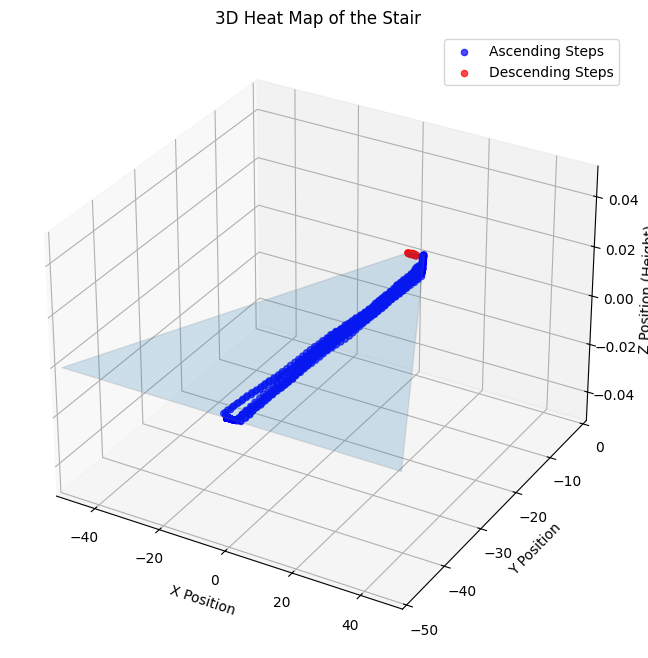

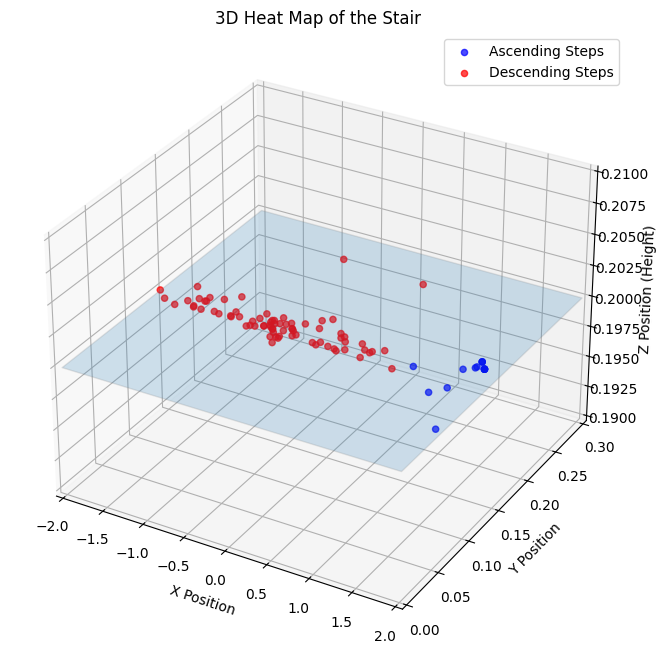

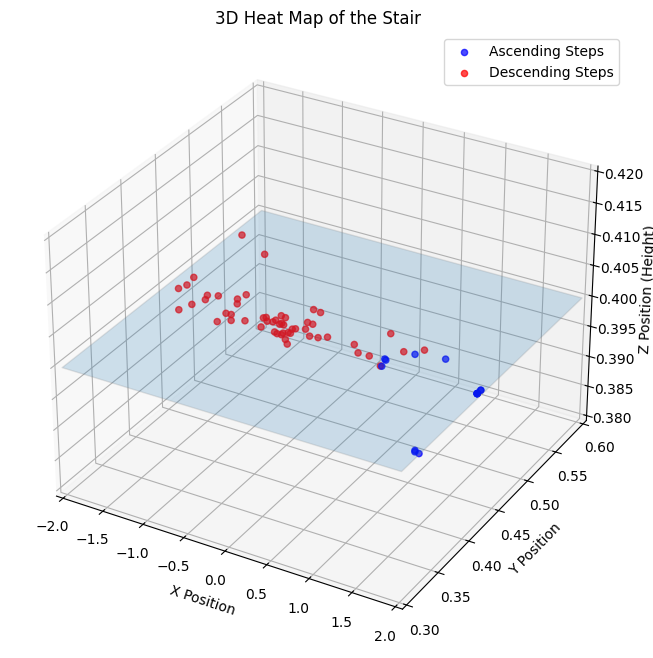

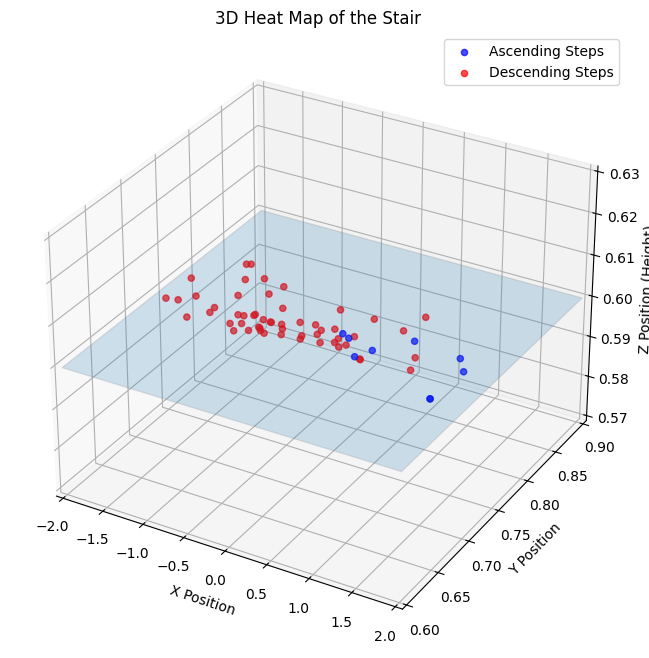

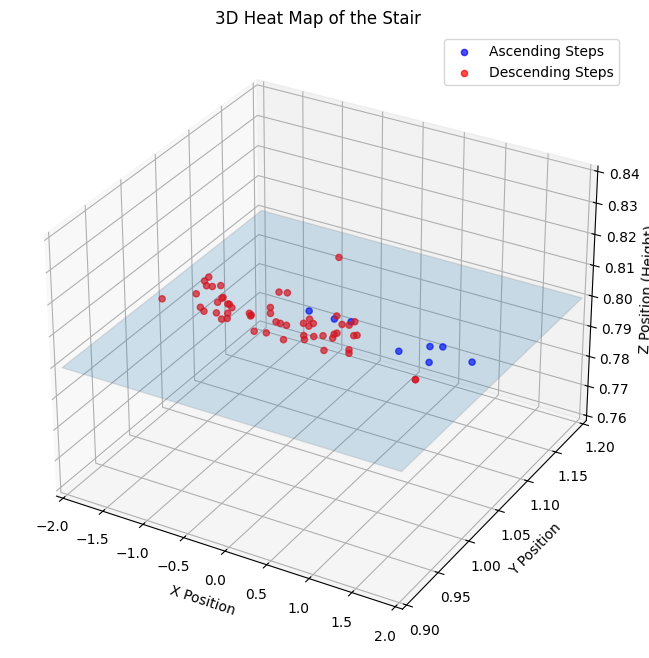

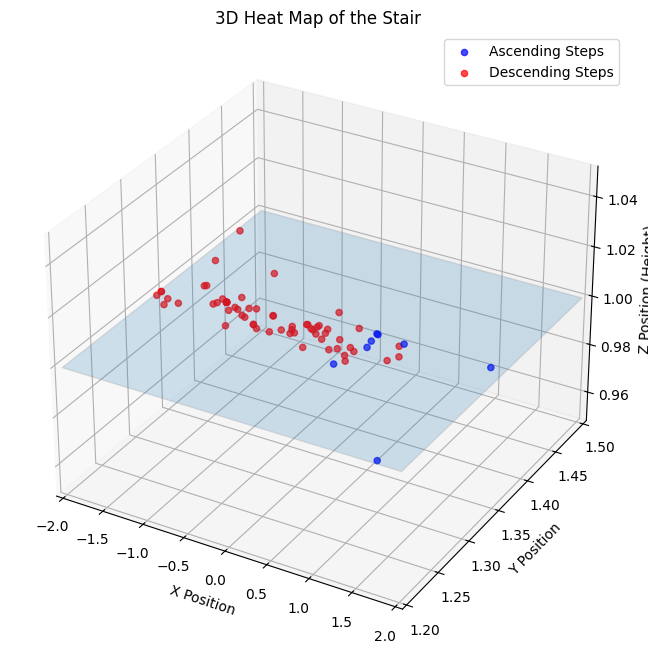

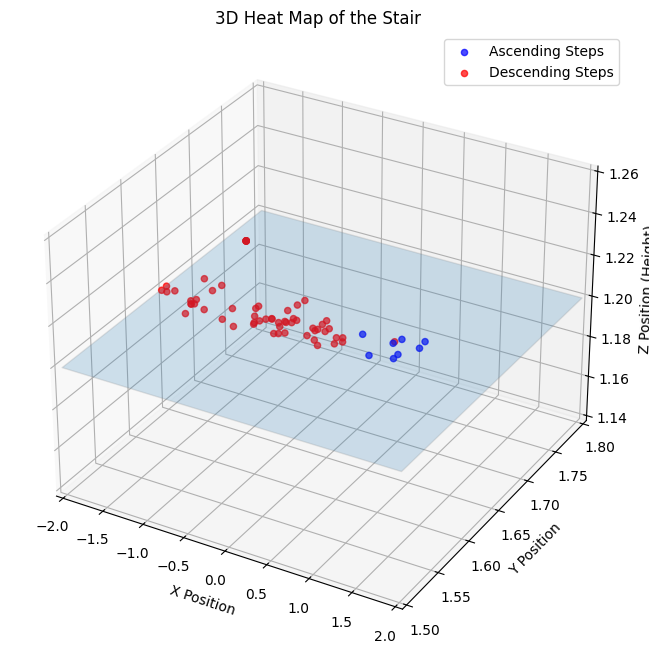

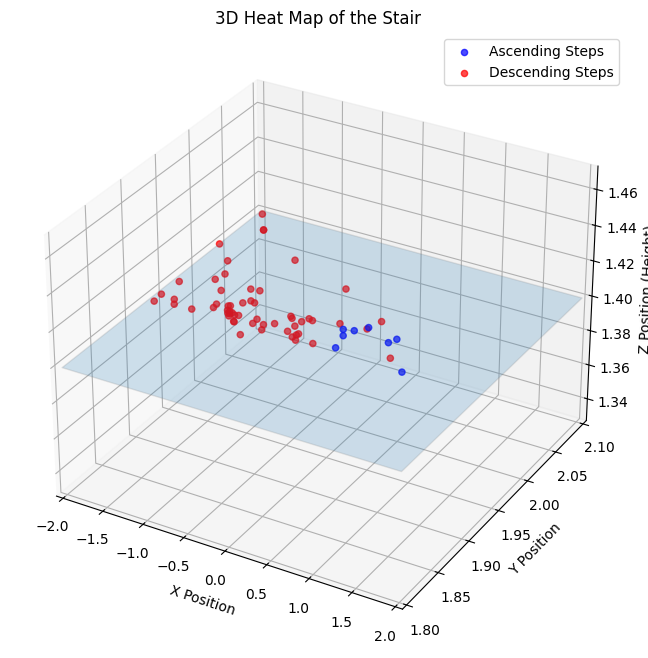

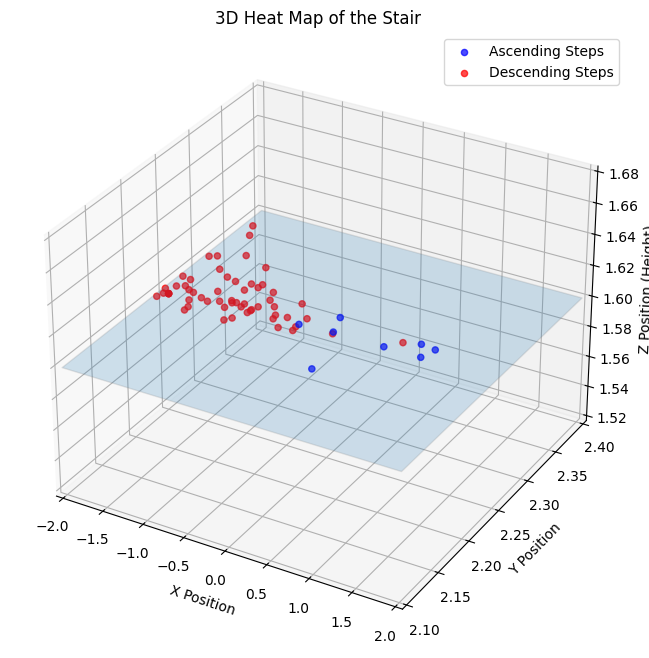

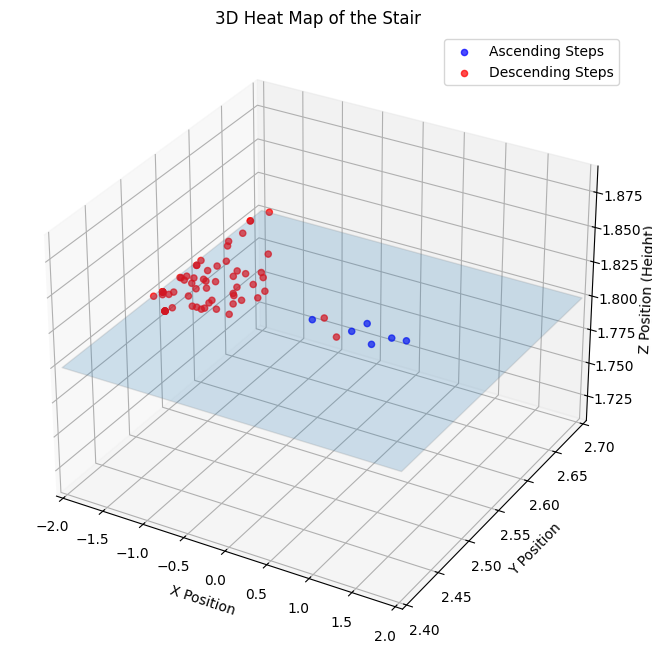

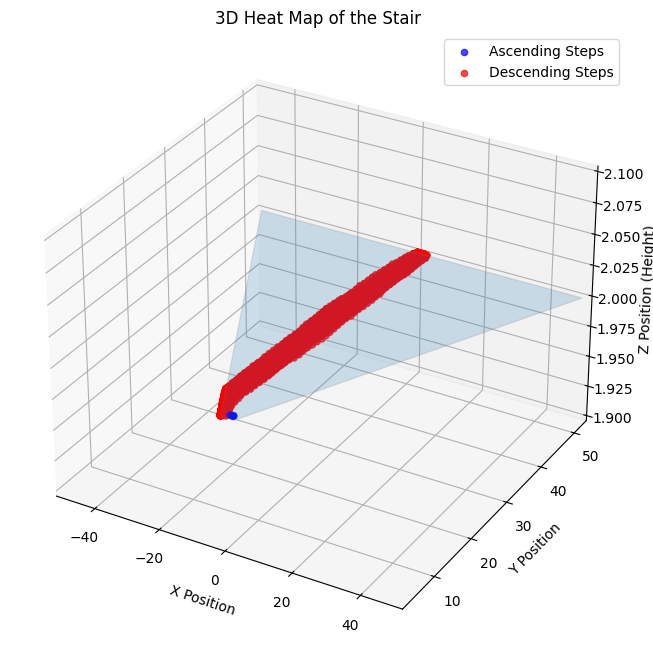

In [187]:
for stair in simulation.staircase.stairs:
    stair.plot_heat_map()